## Reinforcement Learning Tarea 1 - K Armed Bandits

#### Mariano Chicatún, Nicolás Grezzi

### Objetivos:
Demostrar entendimiento sobre K-Armed Bandits, implementar varios algoritmos vistos en el curso teórico y comparar su performance en un mismo problema (ambiente).

### A entregar:
- Implementación de agente arbitrario.
- Implementación de agente epsilon-greedy.
- Implementación de agente epsilon-greedy optimista.
- Implementación de agente upper confidence bound.
- Grafique la evolución de las recompensas (reward) a lo largo del tiempo para cada algoritmo, promediado sobre 2000 ejecuciones.
- Escriba un reporte sobre sus implementaciones comparando los distintos agentes implementados.

### Instalación y carga de ambiente

`git clone https://github.com/JKCooper2/gym-bandits.git`

`cd gym-bandits`

`pip install .`

In [3]:
# Para usarlo desde Google Colab o mi Jupyter Notebook
#!git clone https://github.com/JKCooper2/gym-bandits.git
!cd gym-bandits
!pip install gym-bandits/

fatal: destination path 'gym-bandits' already exists and is not an empty directory.
Processing ./gym-bandits
  Preparing metadata (setup.py) ... done
  Using cached gym-0.26.2-py3-none-any.whl
  Using cached gym_notices-0.0.8-py3-none-any.whl (3.0 kB)
  Using cached cloudpickle-2.2.1-py3-none-any.whl (25 kB)
  Created wheel for gym-bandits: filename=gym_bandits-0.0.2-py3-none-any.whl size=5216 sha256=c731b0f7bd69e090e5a2af987a999ca7e49f880ce47366a29e43ab2661e5cda8
  Stored in directory: /Users/nicolasgrezzi/Library/Caches/pip/wheels/4a/6e/a8/5fb520a9c43ce399eb67cf093fe10309b0a5e4e2a46c48d1ad
Successfully built gym-bandits


## Descripción del ambiente a usar

Vamos a usar GymBandits, una libreria diseñada para ser utilizada sobre OpenAi Gym (https://gym.openai.com/) pero orientada a Armed Bandits. 

Recordando el teórico, sabemos que un K Armed Bandit representa una maquina tragamonedas con multiples brazos (K) y donde nuestra recompensa depende de cual brazo tiremos.

En este caso particular, `BanditTenArmedGaussian` es el ambiente a utilizar (página 30 del libro de Sutton y Barto), cuenta con 10 brazos (K=10) y por cada interaccion con el ambiente (`step`) nustra recompensa (reward) depende de que brazo elegimos entre los 10 posibles. En este ambiente, todos los brazos tienen una recompensa (que puede ser negativa en algunos casos) y nuestro objetivo es diseñar agentes que maximicen la suma total de recompensas a lo largo de 1000 interacciones con el ambiente (`1000 steps`).

## Definicion del ambiente e imports necesarios

In [ ]:
#conda install matplotlib

In [16]:
import gym
import random
import gym_bandits
import numpy as np
import matplotlib.pyplot as plt

def get_env():
    return gym.make("BanditTenArmedGaussian-v0")    

In [17]:
sample_env = get_env()
sample_env.action_space

Discrete(10)

In [18]:
number_steps = 1000

In [19]:
from Agent import Agent

### Implementación de agente arbitrario

In [22]:
class RandomAgent(Agent):
    def __init__(self, name):
        super().__init__(name)        

    def reset_internal_state(self):
        pass

    def select_action(self, game_state):
        return self.environment.action_space.sample()
   
    def update_internal_state(self, observation, action, reward):
        pass
    
    def get_extra_info(self):
        return None

# Example run
random_agent = RandomAgent("RandomAgent")

logs, info = random_agent.play(n_steps = 1000, environment = sample_env)

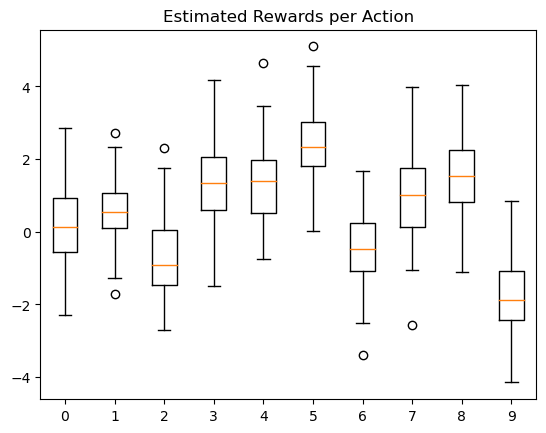

In [23]:
data = list(map(lambda x: np.array(x), logs['actions_rewards'].values()))
labels = list(logs['actions_rewards'].keys())
fig1, ax1 = plt.subplots()
ax1.set_title('Estimated Rewards per Action')
a = ax1.boxplot(data, labels = labels)

In [25]:
type(data[0])

numpy.ndarray

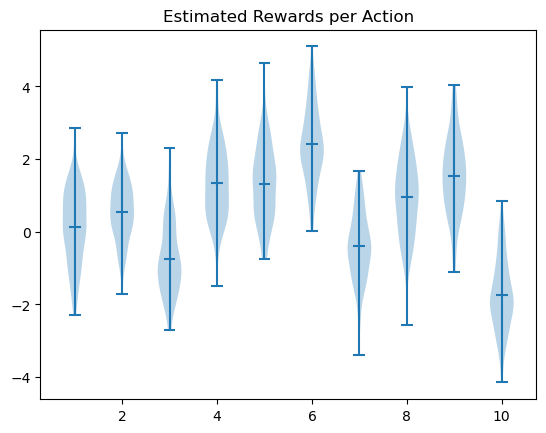

In [34]:
fig1, ax1 = plt.subplots()
ax1.set_title('Estimated Rewards per Action')
a = ax1.violinplot(data, showmeans=True, showmedians = False)

In [35]:
print (f"Accumulated reward: {sum(logs['rewards']):.2f}")
print (f"Mean reward: {logs['rewards'].mean():.2f}")

Accumulated reward: 498.91
Mean reward: 0.50


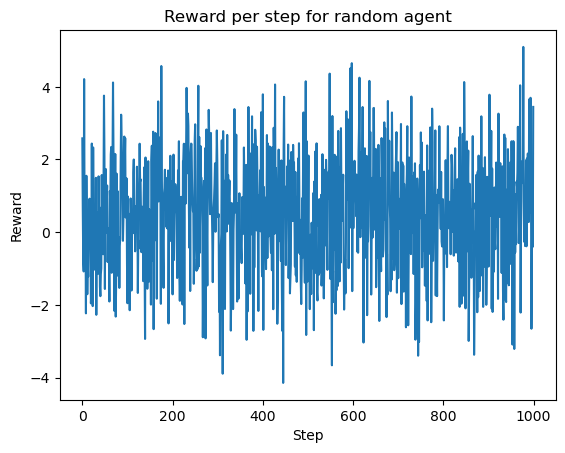

In [36]:
# Example plot
plt.plot(range(number_steps), logs['rewards'])
plt.xlabel("Step")
plt.ylabel("Reward")
plt.title("Reward per step for random agent")
plt.show()

### Implementación de agente epsilon-greedy

In [116]:
class EpsilonGreedyAgent(Agent):
    def __init__(self, name, epsilon):
        super().__init__(name)  
        self.epsilon = epsilon

    def reset_internal_state(self):
        self.q = np.zeros(self.environment.action_space.n)
        self.n = np.zeros(self.environment.action_space.n)

    def select_action(self, game_state):
        rnd = random.random()                                     #elijo numero entre 0 y 1
        if rnd < self.epsilon:                                    #si es menor a epsilon, exploRo
            action = self.environment.action_space.sample()
        else:                                                     # si es mayor a epsilon, exploTo
            action = np.argmax(self.q)
            
        return action
   
    def update_internal_state(self, observation, action, reward):
        self.n[action] = self.n[action] + 1
        self.q[action] = self.q[action] + (1/self.n[action])*(reward - self.q[action])
    
    def get_extra_info(self):
        return {"q_a":self.q, "n_a":self.n}

# Example run
epsilon_greedy_agent = EpsilonGreedyAgent("EpsilonGreedyAgent", 0.3)

logs, info = epsilon_greedy_agent.play(n_steps = 1000, environment = sample_env)
print(info['n_a'])
print(info['q_a'])
print (f"Accumulated reward: {sum(logs['rewards']):.2f}")
print (f"Mean reward: {logs['rewards'].mean():.2f}")

[ 31.  35.  31.  34.  34. 707.  42.  31.  26.  29.]
[ 0.00785692  0.33780018 -0.63994607  1.56710612  1.44723166  2.34431523
 -0.46014454  1.05882509  1.56756241 -1.3776929 ]
Accumulated reward: 1766.45
Mean reward: 1.77


### Implementación de agente epsilon-greedy optimista

In [118]:
class OptimisticEpsilonGreedyAgent(Agent):
    def __init__(self, name, epsilon, q_1):
        super().__init__(name) 
        self.epsilon = epsilon
        self.q_1 = q_1      

    def reset_internal_state(self):
        #self.q = np.ones(self.environment.action_space.n)*self.q_1
        self.q = np.full(self.environment.action_space.n,float(self.q_1))
        self.n = np.zeros(self.environment.action_space.n)

    def select_action(self, game_state):
        rnd = random.random()
        #if self.n == 0:
         # action = self.q_1
        #else: 
        if rnd < self.epsilon:
          action = self.environment.action_space.sample()
        else:
          action = np.argmax(self.q)
        return action
   
    def update_internal_state(self, observation, action, reward):
        self.n[action] = self.n[action] + 1
        self.q[action] = self.q[action] + (1/self.n[action])*(reward - self.q[action])
    
    def get_extra_info(self):
        return {"q_a":self.q,"n_a":self.n}

# Example run
optimistic_epsilon_greedy_agent = OptimisticEpsilonGreedyAgent("OptimisticEpsilonGreedyAgent", 0.3, q_1 = 10)

logs, info = optimistic_epsilon_greedy_agent.play(n_steps = 1000, environment =sample_env)
print(info['n_a'])
print(info['q_a'])
print (f"Accumulated reward: {sum(logs['rewards']):.2f}")
print (f"Mean reward: {logs['rewards'].mean():.2f}")

[ 19.  26.  31.  32.  35. 739.  22.  34.  29.  33.]
[ 0.19711908  0.41698166 -0.52435135  1.64312781  1.19006089  2.33818815
 -0.7245654   0.91006676  1.66786719 -1.42102252]
Accumulated reward: 1836.96
Mean reward: 1.84


### Implementación de agente upper confidence bound

In [131]:
class UCBAgent(Agent):
    def __init__(self, name, C):
        super().__init__(name)
        self.C = C        

    def reset_internal_state(self):
        self.q = np.zeros(self.environment.action_space.n)
        self.n = np.ones(self.environment.action_space.n)

    def select_action(self, game_state):
        t = np.sum(self.n)
        action = np.argmax(self.q+self.C*np.sqrt(np.log(t)/self.n))
        return action
   
    def update_internal_state(self, observation, action, reward):
        self.n[action] = self.n[action] + 1
        self.q[action] = self.q[action] + (1/self.n[action])*(reward - self.q[action]) 
    
    def get_extra_info(self):
        return {"q_a":self.q,"n_a":self.n}

# Example run
UCB_agent = UCBAgent("UCBAgent", 1)

logs, info = UCB_agent.play(n_steps = 1000, environment = sample_env)
print(info['n_a'])
print(info['q_a'])
print (f"Accumulated reward: {sum(logs['rewards']):.2f}")
print (f"Mean reward: {logs['rewards'].mean():.2f}")

[  2.   2.   3.   2.   7. 978.   2.   3.   9.   2.]
[-0.22201248 -0.03077813 -0.05747599  0.25996331  0.97969861  2.29566536
 -0.29267377  0.63770685  1.33305689 -0.61984282]
Accumulated reward: 2263.95
Mean reward: 2.26


### Reporte

In [132]:
def calculate_mean_rewards_and_selected_optimal_action_by_step(n_runs, n_steps, agent_constructor, param):
    many_rewards = []
    many_selected_best_action = []
    for i in range(n_runs):
        env = get_env()
        agent = agent_constructor(param)
        logs, info = agent.play(n_steps, env)
        many_rewards.append(logs['rewards'])
        many_selected_best_action.append(logs['selected_best_action'])
    mean_rewards = np.mean(many_rewards, axis = 0)
    mean_selected_best_action = np.mean(many_selected_best_action, axis = 0)    
    return {"mean_rewards": mean_rewards, "mean_selected_best_action":mean_selected_best_action}

In [133]:
from functools import partial 

parameters_eps_greedy = [0, 0.1, 0.01]

#Para epsilon greedy optimista con tasa de actualización no fija con que Q0 esté sobre la media basta (default 10 = OK)
parameters_eps_greedy_opt = [0, 0.1, 0.01]


parameters_ucb = [0.25, 0.5, 1, 2, 4]

n_runs = 2000
n_steps = 1000

eps_greedy_results = list(map(lambda x: (x,calculate_mean_rewards_and_selected_optimal_action_by_step(n_runs, n_steps, partial(EpsilonGreedyAgent, "EpsilonGreedyAgent"),x)), parameters_eps_greedy))

eps_greedy_opt_results = list(map(lambda x: (x,calculate_mean_rewards_and_selected_optimal_action_by_step(n_runs, n_steps, partial(OptimisticEpsilonGreedyAgent, "EpsilonGreedyAgent", q_1 = 10)  ,x)), parameters_eps_greedy_opt))

ucb_results = list(map(lambda x: (x,calculate_mean_rewards_and_selected_optimal_action_by_step(n_runs, n_steps, partial(UCBAgent, "UCBAgent"),x)), parameters_ucb))

In [134]:
def plot_results(results, param_name, metric, plot_title, x_label, y_label, n_steps):
    plt.figure(figsize=(10,5))
    for param, means in results:
        plt.plot(range(n_steps), means[metric], label=param_name+' = '+str(param))        
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(plot_title)
    plt.legend()
    plt.show()

#### Epsilon Greedy:

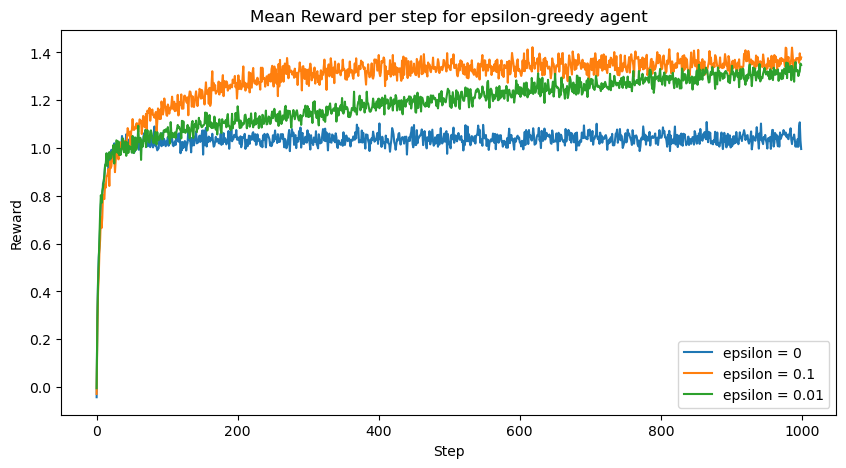

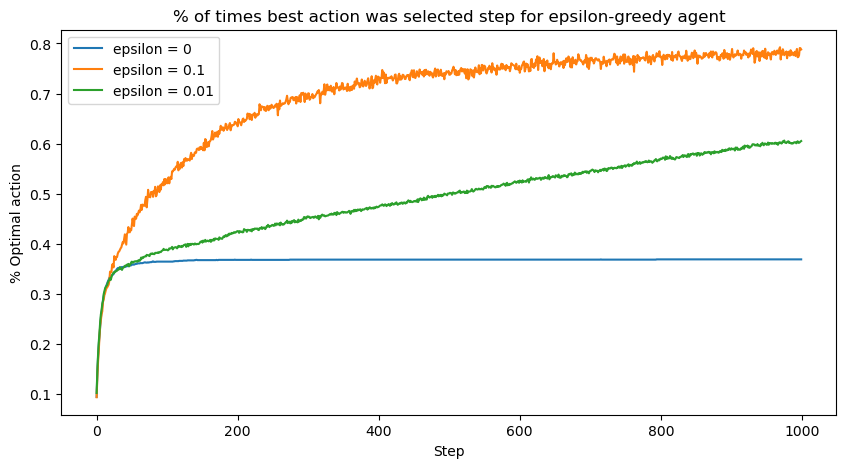

In [135]:
plot_results(eps_greedy_results, "epsilon","mean_rewards","Mean Reward per step for epsilon-greedy agent","Step","Reward", n_steps)
plot_results(eps_greedy_results, "epsilon","mean_selected_best_action","% of times best action was selected step for epsilon-greedy agent","Step","% Optimal action", n_steps)

#### Comentarios:

En este caso podemos ver que al ser €=0, converge de manera muy rápida a un reward apenas mayor a 1, pero el algoritmo una vez que explota no va a explora, la accion es siempre el propio q y por lo tanto no va a encontrar nuevos valores para evolucionar y alcanzar una mejor recompenza.

En el caso de €>0, vemos que el algoritmo si recurre a la exploración ademas de la explotación, y que según que tan grande sea el valor, va a incurrir más rápido en la busqueda de alcanzar una mayor recompenza, siempre aumentando el % con el que elige la acción óptima para ello:
* Para el caso de €=0.1 alcanza siempre obtiene un valor de reward mejor al resto de los algoritmos durante las 100 iteraciones, alcanzando un valor mayor a 1.3.
* Para el caso de €=0.01, vemos que la exploracion ocurre al principio de forma más lenta, va mejorando el % con los que elije la acción optima, y sobre el final de las 1000 iteraciones parece ser claro que va a superar al caso anterior, obteniendo un mejor valor de reward.

#### Epsilon Greedy Optimista:

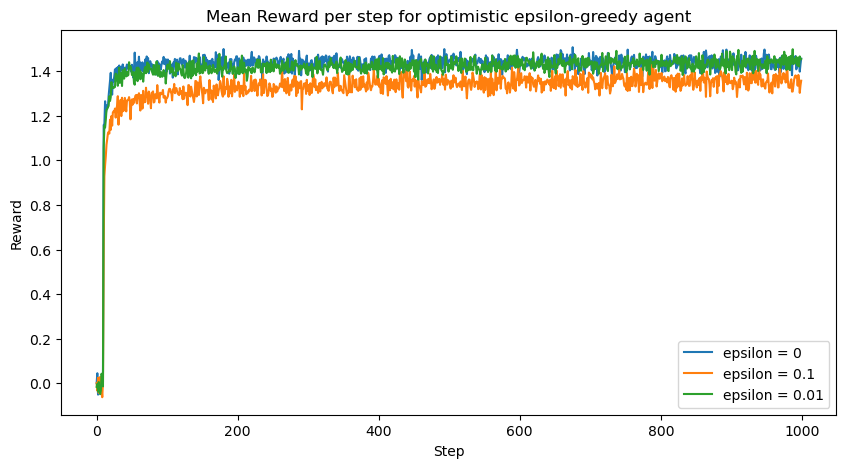

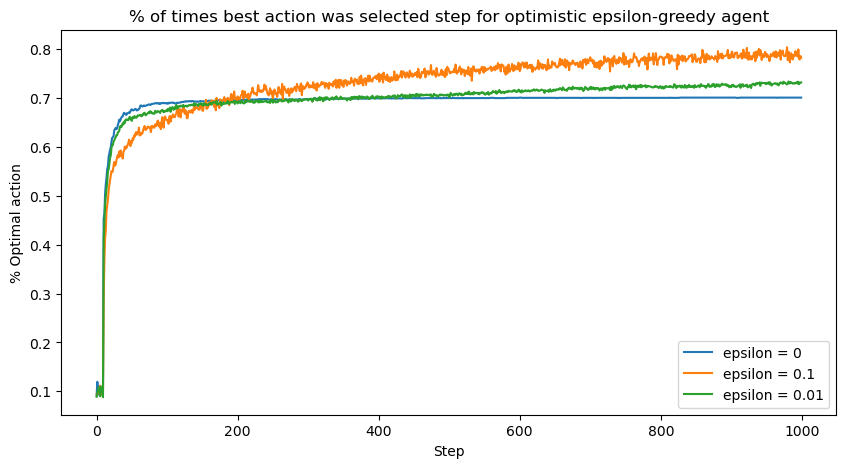

In [136]:
plot_results(eps_greedy_opt_results, "epsilon","mean_rewards","Mean Reward per step for optimistic epsilon-greedy agent","Step","Reward", n_steps)
plot_results(eps_greedy_opt_results, "epsilon","mean_selected_best_action","% of times best action was selected step for optimistic epsilon-greedy agent","Step","% Optimal action", n_steps)

#### Comentarios:
En este caso como la exploración de todas las acciones es forzada al menos una vez, vemos que el comportamiento del algoritmo ya desde el comienzo tiene un % alto de la probabilidad de que la acción elegida sea la óptima.

* Vemos nuevamente que para €=0 una vez que exploró, se mantiene con el mejor valor obtenido y no realiza más exploraciónes, sin embargo en este caso logra obtener el mejor resultado de rewards.
* Muy próximo lo sigue el caso para €=0.01, que saca provecho de el gran valor de Q al comienzo y luego explora de forma "lenta pero segura".
* En este caso, el comportamiento para €=0.1, si bien alcanza su estabilidad en el reward de forma más rapida, es muy similar al caso anterior ya que de por si era un valor que permitia al algoritmo ser exploratorio.

Disminuyendo € lo que estamos logrando es que que el agente explore menos, con lo cual la recompensa va a tender a crecer más lentamente pero con la posibilidad de llegar a un valor más alto a coste de un número de pasos mayor.  

#### UCB

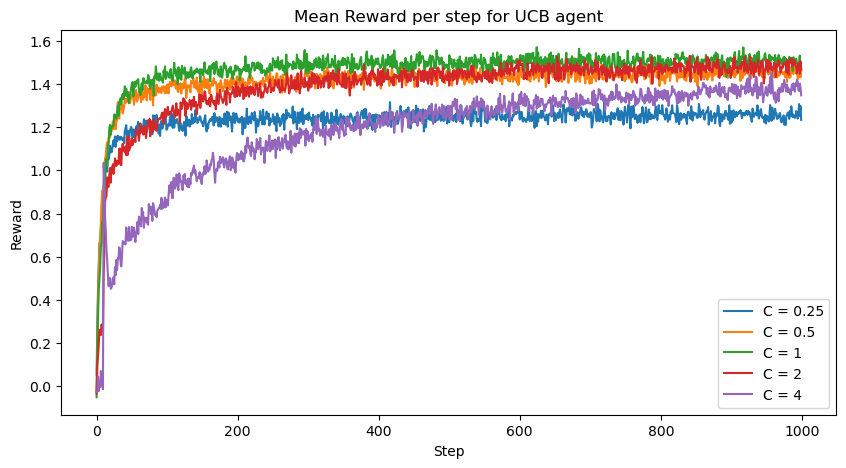

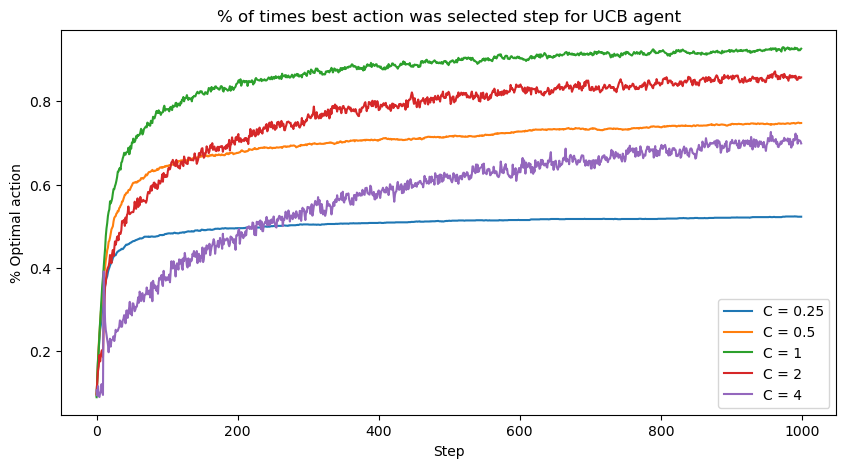

In [137]:
plot_results(ucb_results, "C","mean_rewards","Mean Reward per step for UCB agent","Step","Reward", n_steps)
plot_results(ucb_results, "C","mean_selected_best_action","% of times best action was selected step for UCB agent","Step","% Optimal action", n_steps)

#### Comentarios:

En el algoritmo UCB siempre se realiza la exploración, tenemos C llamado nivel de confianza y por como se define la fórmula del algoritmo, determina que tanto impacto tendrá el termino de la raiz cuadrada en este, que modifica siempre de esta forma el valor de Q en cada iteración. En otras palabras, controla el grado de exploración.

* Cuando C < 1, en las primeras iteraciones vemos que el término de la raíz tiene menor impacto en el algoritmo, y por lo tanto podemos ver que comienza teniendo un comportmiento similar al Epsilon Greedy Optimistic, ya que rapidamente alcanza un valor alto de reward pero luego no tiene una buena probabilidad de elegir la mejor acción. De todas formas, siempre tendrá posibilidad de elegir una mejor acción, ya que está siempre forzado a variar aunque sea levemente el valor de la acción. Esto se puede ver en los graficos azul y amarillo del segundo plot.

* Cuando C > 1, contrario al caso anterior, cuando C=2 o C=4 vemos que al comienzo le es más dificil al algrotimo encontrar la acción óptima, pero luego esta probabilidad crece y finalmente se puede notar que la recompenza que logra alcanzar UCB con C>1 es más alta que con los C<1 cerca de las 500 iteraciones. Se puede ver que aquí existe un trade-off entre que tan rápido se obtiene un buen valor de reward, contra un mejor reward pero que demanda más tiempo y computo.

* Cuando C = 1, encontramos en este caso el mejor de los resultados. En las primeras 200 iteraciones ya se está eligiendo la mejor accion con un 80% de probabilidad y se ve que alcanza el mayor valor de reward de todos los casos frente a los resultados de los otros parámetros (al menos en las primeras 1000 iteraciones). El grafico verde siempre está por encima de los otros resultados para cualquier iteración.

#### A continuación compararemos los que mejor resultado dan en una misma gráfica

In [138]:
eps_greedy_results_means = list(map(lambda x: (x[0], x[1],np.mean(x[1]['mean_rewards'])), eps_greedy_results))
eps_greedy_opt_results_means = list(map(lambda x: (x[0], x[1],np.mean(x[1]['mean_rewards'])), eps_greedy_opt_results))
ucb_results_means  = list(map(lambda x: (x[0], x[1],np.mean(x[1]['mean_rewards'])), ucb_results))

In [139]:
best_eps_greedy = max(eps_greedy_results_means,key=lambda item:item[2])
best_eps_greedy_opt = max(eps_greedy_opt_results_means,key=lambda item:item[2])
best_ucb = max(ucb_results_means,key=lambda item:item[2])

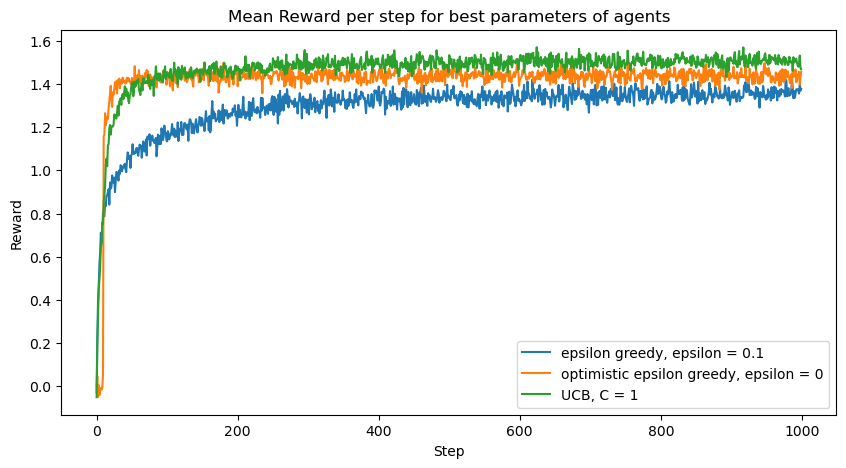

In [140]:
plt.figure(figsize=(10,5))    
plt.plot(range(n_steps), best_eps_greedy[1]['mean_rewards'], label='epsilon greedy, epsilon = '+str(best_eps_greedy[0]))
plt.plot(range(n_steps), best_eps_greedy_opt[1]['mean_rewards'], label='optimistic epsilon greedy, epsilon = '+str(best_eps_greedy_opt[0]))
plt.plot(range(n_steps), best_ucb[1]['mean_rewards'], label='UCB, C = '+str(best_ucb[0]))
plt.xlabel("Step")
plt.ylabel("Reward")
plt.title("Mean Reward per step for best parameters of agents")
plt.legend()
plt.show()

#### Comentarios:

En el plot final vemos una comparación entre los 3 algoritmos, donde se muestran los resultados obtenidos
por estos con los parámetros que dieron los mejores resultados en cada uno de ellos.

Si bien los 3 tienen una buena performance, el que mejor se desempeña es UCB, alcanzando el valor más alto de reward de todos.

* Podemos notar que en UCB con C=1, ya cerca de los primeros 100 steps comienza a tener un mejor desempeño que el algoritmo Optimisitc Epsilon Greedy, alcanzando un reward próximo a 1.5 y manteniendose asi durante el resto de los steps.
* Para el resultado de Op. Ep. Greedy con €=0, vemos que el reward que alcanza esta por encima de 1.4 pero no logra llegar a 1.5. Sin embargo, tiene la ventaja frente al resto de los algortimos de que lo alcanza muy tempranamente, dentro de los 50 primeras steps.
* El que peor desempeño tiene de los 3 es el Epsilon Greedy con €=0.1, y recien luego de los 400 steps comienza a tener un comportamiento asintótico, creciendo muy lentamente, alcanzando un reward próximo a 1.3 en los 1000 steps